## 학습된 YOLO 모델을 사용하여 잎 탐지하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### YOLO 모델을 사용하기 위해 라이브러리 설치

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 10.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

### test 이미지 폴더에서 이미지의 경로를 가져오는 함수
- 지정된 디렉토리에서 이미지 파일들의 경로를 리스트로 반환
  - 사용가능한 이미지 확장자(추가 가능)
    - ["json", "txt", "jpg", "JPG", "png", "PNG"]

In [ ]:
import glob
import os
def get_img_path_list(root_dir, extensions):

  img_list = list()
  for ext_label in extensions:
      img_list.extend(glob.glob(os.path.join(root_dir, f"*.{ext_label}")))

  return img_list

### NMS(Non-Maximum Suppression) 함수
- YOLO를 통해 이미지를 검출할 때, 비슷한 위치에 중복된 바운딩 박스(bbox)가 검출되는 것을 방지하는 함수
  - 인자
    - boxes : 탐지된 객체의 바운딩 박스(bbox) 좌표 리스트.
    - confidences : 각 바운딩 박스의 신뢰도 점수를 담고 있는 리스트로, 신뢰도가 낮은 바운딩 박스를 제거하는 데 사용
    - iou_threshold : 두 개의 바운딩 박스 간의 겹침 정도를 측정하는 지표인 IoU(Intersection over Union) 임계값으로 이 값을 이용하여 동일한 객체를 탐지하는 중복된 바운딩 박스를 제거할 수 있다.

In [81]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def nms(boxes, confidences, iou_threshold=0.5):
    if len(boxes) == 0:
        return []

    # 바운딩 박스 좌표를 numpy 배열로 변환
    boxes = np.array(boxes)
    confidences = np.array(confidences)

    # 바운딩 박스의 좌표와 넓이를 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 신뢰도 점수를 기준으로 정렬
    order = confidences.argsort()[::-1]

    keep = []  # 유지할 바운딩 박스의 인덱스를 저장할 리스트

    while order.size > 0:  # 남은 바운딩 박스가 없을 때까지 반복
        i = order[0]  # 현재 가장 높은 신뢰도를 가진 바운딩 박스의 인덱스
        keep.append(i)

        # 현재 박스와 나머지 박스의 좌표 계산
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 교차 영역의 너비와 높이 계산
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h  # 교차 영역의 면적

        # IoU (Intersection over Union) 계산
        iou = inter / (areas[i] + areas[order[1:]] - inter)  # 교차 영역 / 합집합 영역

        # IoU가 임계값 이하인 인덱스를 찾음
        inds = np.where(iou <= iou_threshold)[0]

        # 남은 바운딩 박스 중에서 현재 처리한 박스를 제외한 박스들로 order를 갱신
        order = order[inds + 1]

    return keep

### 모델 호출 및 탐지 결과 조정 및 시각화 함수
- 여러 이미지에 대해 YOLO 모델을 사용하여 객체를 탐지하고, 특정 조건에 따라 결과를 조정하고 시각화하여 사용자에게 제공
  - 기능
    - 객체 검출 결과 중 신뢰도가 높은 순으로 상위 5개의 객체만을 시각화하여 반환.
    - 동일한 객체가 중복으로 검출되는 것을 방지하기 위해 NMS(비최대 억제) 알고리즘을 사용.
  - 인자
    - model : YOLO 모델 객체.
    - image_paths : 객체를 탐지할 이미지들의 경로를 담은 리스트.

In [ ]:
def plot_images(model, image_paths):
    results = model(image_paths, conf=0.01)

    for index, result in enumerate(results):
        # 이미지 읽기
        image = cv2.imread(image_paths[index])

        boxes = []
        confidences = []

        # 객체 검출 결과 저장
        for box in result.boxes:
            box_boundary = box.xyxy[0]
            conf = box.conf[0]
            boxes.append([int(box_boundary[0]), int(box_boundary[1]), int(box_boundary[2]), int(box_boundary[3])])
            confidences.append(float(conf))

        # NMS 적용하여 거의 비슷한 위치의 바운드 박스 제거
        keep = nms(boxes, confidences)

        for i in keep[:5]:
            box_boundary = boxes[i]
            conf = confidences[i]

            # 객체 박스 그리기
            cv2.rectangle(image, (box_boundary[0], box_boundary[1]), (box_boundary[2], box_boundary[3]), (0, 255, 0), 2)

            # 객체 신뢰도 출력
            cv2.putText(image, f'{conf:.3f}', (box_boundary[0], box_boundary[1] + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # 이미지 출력
        cv2_imshow(image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


### 실행

In [ ]:
from ultralytics import YOLO

# 학습된 가중치 파일 적용
model = YOLO('/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/models/leaf_detection_v2.pt')

In [86]:
# 해당 폴더 안의 모든 이미지 파일의 잎 위치 탐지
test_img_path="/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2"

extensions = ["json", "txt", "jpg", "JPG", "png", "PNG"]

image_paths = get_img_path_list(test_img_path, extensions)
print(len(image_paths))
print(image_paths)

8
['/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/tomato1.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/Lettuce1.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/pepper1.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/pepper2.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/Lettuce2.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/tomato2.jpg', '/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data

In [87]:
# 함수 호출하여 이미지 플롯 표시
plot_images(model, image_paths[::-1])

### (번외) YOLO 학습
- Yolo 모델 사용법
  - 하이퍼파라미터
    - conf : 기본값 - 0.25, 신뢰도의 임계값을 지정할 수 있다
    - iou : 기본값 - 0.7, NMS를 활용하여 겹치는 객체를 줄일 수 있다
      - 본 파일에선 직접 구현하여 사용해보았다.
    - agnostic_nms: 서로 다른 클래스여도 NMS를 통해 중복을 방지한다.
    - max_det : 이미지당 허용되는 최대 검출 수로 검출할 수 있는 객체를 제한
      - 본 파일에선 직접 구현하여 사용해보았다.
    - imgsz:  기본값 - (640, 640), 이미지가 모델에 입력되기 전 재조정될 크기
    - divice: 추론에 사용할 장치를 지정 (GPU, CPU 등등)

  -  YOLO모델에 입력할 수 있는 이미지 타입
    - str(URL, 경로), PIL.Image, np.ndarray, torch.Tensor, 비디오, 디렉토리 경로, YouTube URL 등등
      - 그냥 폴더 경로를 넣어도 폴더 안에 이미지 파일을 자동으로 읽어 측정해 준다.

  - 공식 문서
    - https://docs.ultralytics.com/modes/predict/#inference-arguments

In [52]:
results = model(image_paths[0], conf=0.01)


image 1/1 /content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/data/test_img/V2/tomato1.jpg: 384x640 2 상추s, 658.6ms
Speed: 3.7ms preprocess, 658.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


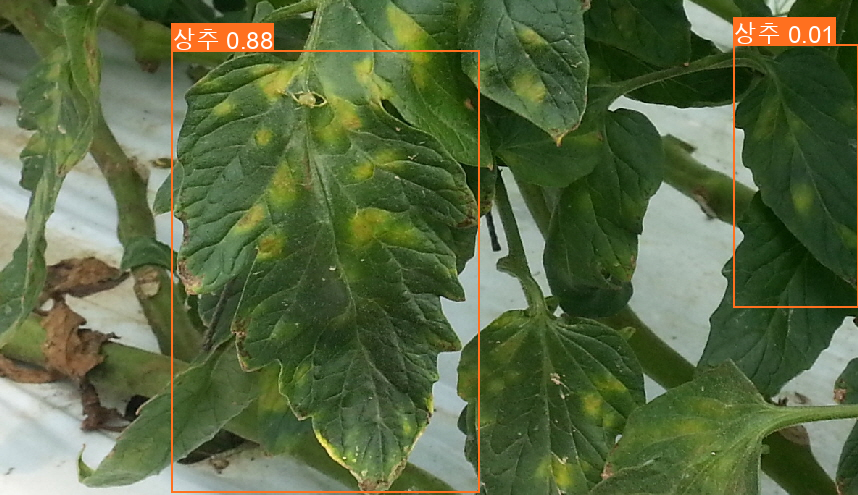

In [53]:
cv2_imshow(results[0].plot())

In [85]:
test_list = [2,3,5]
for i in test_list[:6]:
  print(i)

2
3
5


In [55]:
# 검출된 객체들의 bbox를 개별로 출력한다.
for i in results[0].boxes[:5]:
  print(i.xyxy)

tensor([[171.6900,  50.4456, 479.9969, 492.7531]])
tensor([[733.3812,  44.3428, 858.0000, 307.7319]])


In [61]:
print(results[0].boxes.xyxy)
print(results[0].boxes.conf) # 신뢰도
print(results[0].boxes.cls) # 클래스 번호

print(int(results[0].boxes.xyxy[0][0]))

tensor([[171.6900,  50.4456, 479.9969, 492.7531],
        [733.3812,  44.3428, 858.0000, 307.7319]])
tensor([0.8767, 0.0143])
tensor([2., 2.])
171
